# Striped Skunk Recent Occurrence Records Summary
This notebook is a tool for exploring data sets requested from GBIF (and eventually other sources), and mostly for developing criteria for filtering records (filter sets).  When the entire notebook is run, it retrieves records according to the filter sets specified and saves the results (records and some summary tables) in an sqlite database.  Some information is pulled from the parameters.sqlite database that is saved in this repository.

### General Setup

In [1]:
%matplotlib inline
import sqlite3
import pprint
import json
import pandas as pd
import numpy as np
pd.set_option('display.width', 600)
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_rows', 150)
from IPython.display import Image
from pygbif import occurrences
import matplotlib.pyplot as plt
import os
from datetime import datetime
t1 = datetime.now()
import sys
sys.path.append("T:/GAP/Data") # Path to config file.  User specific
import gapconfig as config

There is a bug with mpl_toolkits, the following code is a temp fix, hopefully.
https://stackoverflow.com/questions/52911232/basemap-library-using-anaconda-jupyter-notebooks-keyerror-proj-lib/54087410#54087410

In [2]:
os.environ['PROJ_LIB'] = r'c:\Users\nmtarr\AppData\Local\Continuum\miniconda3\envs\wrangler\Library\share'

### Set Variables
Fill out stuff in this cell.  

Notes:
default_coordUncertainty -- coordinateUncertaintyInMeters is often not provided.  Here is an option to use a default.  If you don't want anything entered, set this equal to False (boolean, not string).

In [3]:
species_id = 'mstskx0'
summary_name = 'striped'
gbif_req_id = 'GBIFr25'
gbif_filter_id = 'GBIFf10'
workDir = 'P:/Proj3/USGap/Vert/USranges/version2/'
codeDir = 'T:/code/wildlife-wrangler/'
sys.path.append(codeDir)
import repo_functions as functions
inDir = workDir + 'Inputs/'
outDir = workDir + 'Outputs/'
default_coordUncertainty = 1000 # Note above.
#SRID_dict = {'WGS84': 4326, 'AlbersNAD83': 5070} # Used in file names for output.
paramdb = 'P:/Proj3/USGap/Vert/DBase/wildlife-wrangler.sqlite'
spdb = outDir + species_id + gbif_req_id + gbif_filter_id + '.sqlite'

username = config.gbif_username
password = config.gbif_password
email = config.gbif_email

print("Notebook run " + str(t1))
print(spdb)

Notebook run 2020-03-17 16:09:22.766430
P:/Proj3/USGap/Vert/USranges/version2/Outputs/mstskx0GBIFr25GBIFf10.sqlite


In [4]:
connjup = sqlite3.connect(paramdb)
cursorjup = connjup.cursor()

# Get some variables
years = connjup.execute("""SELECT years_range 
                           FROM gbif_requests WHERE request_id = '{0}'""".format(gbif_req_id)).fetchone()[0]
gap_id = connjup.execute("""SELECT gap_id
                            FROM species_concepts WHERE species_id = '{0}'""".format(species_id)).fetchone()[0]
common_name = connjup.execute("""SELECT common_name
                                 FROM species_concepts WHERE species_id = '{0}'""".format(species_id)).fetchone()[0]

# Species Concept
Display information on the species from the parameters.sqlite database.

In [5]:
vals = cursorjup.execute("SELECT * FROM species_concepts WHERE species_id = '{0}';".format(species_id)).fetchall()[0]
cols = [x[1] for x in cursorjup.execute("PRAGMA table_info('species_concepts')").fetchall()]
pprint.pprint(dict(zip(cols, vals)))

{'bcb_id': None,
 'common_name': 'striped skunk',
 'detection_distance_meters': 30,
 'ebird_id': None,
 'end_year': None,
 'fws_id': None,
 'gap_id': 'mstskx',
 'gbif_id': '5219380',
 'geometry': None,
 'itis_tsn': '180562',
 'lumped_into': None,
 'notes': 'Family level changes were made around 2005, but did not affect the '
          'species names.  N. Tarr, 1/6/2020.',
 'scientific_name': 'Mephitis mephitis',
 'species_id': 'mstskx0',
 'split_from': None,
 'start_year': 1776,
 'vetted_date': '1/6/2020',
 'vetted_how': 'NS, ITIS, IUCN, GAP, MSW2005',
 'vetted_who': 'N. Tarr'}


# Filters
Display the parameters of the request filter set.  These are deployed during the step where records are retrieved from the API.

In [6]:
df1 = pd.read_sql_query(sql="SELECT * FROM gbif_requests WHERE request_id = '{0}'".format(gbif_req_id), con=connjup)
print("THE REQUEST FILTER SET")
print(df1.loc[0])

THE REQUEST FILTER SET
request_id                            GBIFr25
source                                   GBIF
lat_range                               27,41
lon_range                             -91,-75
years_range                         2015,2020
months_range                             1,12
geoissue                                False
coordinate                               True
country                                    US
geometry                                 None
creator                               N. Tarr
notes           Built for GAP v2 range map...
Name: 0, dtype: object


Display the parameters of the post-request filter set.  These are deployed after the records are retrieved from the API, but before they are stored in the occurrence record sqlite database.

In [7]:
df2 = pd.read_sql_query(sql="SELECT * FROM gbif_filters WHERE filter_id = '{0}'".format(gbif_filter_id), con=connjup)
print("THE POST REQUEST FILTER SET")
print(df2.loc[0])

THE POST REQUEST FILTER SET
filter_id                                           GBIFf10
dataset                                                GBIF
institutions_omit                                      None
collection_codes_omit                                  None
datasets_omit                                          None
has_coordinate_uncertainty                                0
max_coordinate_uncertainty                             5000
bases_omit                                  FOSSIL_SPECIMEN
sampling_protocols_omit                                None
issues_omit                          TAXON_MATCH_HIGHERRANK
duplicates_OK                                          True
creator                                             N. Tarr
notes                         For use in creating GAP ve...
Name: 0, dtype: object


## Filter set justification
Enter your justification for the following settings.

**default_coord_uncertainty:** 1,000 m to be conservative for modern records.

**years_range:** Records from the last 5 years desired.

**months_range:** Non-migratory species so all months of interest.

**geoissue:** GeoIssues would be problematic, potentially skewing results so exclude.

**coordinate:** Coordinates are needed for applying records to range updates.

**country:** GAP ranges are for CONUS so US is appropriate.

**geometry:** No desire to limit within US.

**collection_codes_omit:** Unaware of any reasons to exclude.

**institutions_omit:** Unaware of any reasons to exclude.

**datasets_omit:** Unaware of any reasons to exclude.

**has_coordinate_uncertainty:** Relatively few records exist.  In the interest of using more records, a strategy of keeping all records and applying a default when the field is empty is appropriate.

**max_coordinate_uncertainty:** Records with coordinate uncertainty even near 5,000 m are unlikely to be precise enough to make it through GAP range update screening process.

**bases_omit:** Fossils are of the wrong time scale for the application.

**sampling_protocols_omit:** Unaware of any reasons to exclude.

**issues_omit:** "TAXON_MATCH_HIGHERRANK" could lead to inclusion of other species.

**duplicates:** 

In [8]:
functions.retrieve_gbif_occurrences(codeDir, species_id, inDir, paramdb, spdb, gbif_req_id, gbif_filter_id, 
                                    default_coordUncertainty, outDir, summary_name, username, password, email)

SPATIALITE_SECURITY set to relaxed
Created occurrence db: 0:00:00.900677
Got request params and sorted out geometry constraints: 0:00:00
311 records available
Downloaded records: 0:00:02.998843
Summarized fields returned: 0:00:08.405287
Created summary table of request results: 0:00:00.153151
Performed post-request filtering: 0:00:00
Calculated new columns, deleted some too: 0:00:00.022200
Inserted records into table: 0:00:00.262794
Summarized unique values retained: 0:00:00
Updated occurrences table geometry column: 0:00:00.079002
DUPLICATES ON LATITUDE, LONGITUDE, DATE-TIME INCLUDED
Buffered points: 0:00:02.489358
Exported maps: 0:00:01.742310

Records saved in P:/Proj3/USGap/Vert/USranges/version2/Outputs/mstskx0GBIFr25GBIFf10.sqlite


### How many records made it through the filters?
This is the number that was actually saved in the occurrence record sqlite database.

In [9]:
conn_occ= sqlite3.connect(spdb)
curs_occ = conn_occ.cursor()
record_count = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences WHERE species_id = '{0}'".format(species_id)).fetchone()
print(str(record_count[0]) + " records")

273 records


### Are there duplicate records left?
Duplicates based on latitude, longitude, and date-time should of been removed, with the record with the highest individualCount retained.

In [10]:
dups0 = curs_occ.execute("""SELECT count(occ_id) FROM occurrences WHERE occ_id NOT IN (SELECT occ_id FROM occurrences GROUP BY latitude, longitude, occurrenceDate HAVING max(IndividualCount));""").fetchall()
print(str(dups0[0][0]) + ' duplicate records retained based on xy coordinate and date-time')

273 duplicate records retained based on xy coordinate and date-time


# Sources
#### Pre-filters

In [11]:
tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

filter_sets = [gbif_req_id, gbif_filter_id]

sources = []
for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns = [x[0] for x in columns]
        for col in columns:
            try:
                a = cursorjup.execute("SELECT source FROM {1} WHERE {2} = '{0}'".format(s, tab, col)).fetchone()[0]
                sources.append(a)
            except:
                pass
print(list(set(sources))[0])

sources = pd.read_sql(sql="SELECT * FROM pre_filter_source_counts;", con=conn_occ)
print(sources)

GBIF
  institutionCode collectionCode                    datasetName    0
0     iNaturalist   Observations  iNaturalist research-grade...  310
1     naturgucker    naturgucker                        UNKNOWN    1


#### Post-filters

In [12]:
tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

filter_sets = [gbif_req_id, gbif_filter_id]

sources = []
for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns = [x[0] for x in columns]
        for col in columns:
            try:
                a = cursorjup.execute("SELECT source FROM {1} WHERE {2} = '{0}'".format(s, tab, col)).fetchone()[0]
                sources.append(a)
            except:
                pass
print(list(set(sources))[0])

sql = "SELECT institutionCode, collectionCode, datasetName, COUNT(occ_id) FROM occurrences GROUP BY institutionCode, collectionCode, datasetName;"
sources = pd.read_sql(sql=sql, con=conn_occ)
print(sources)

GBIF
  institutionCode collectionCode                    datasetName  COUNT(occ_id)
0     iNaturalist   Observations  iNaturalist research-grade...            272
1     naturgucker    naturgucker                        UNKNOWN              1


# Bases
#### Pre-filter

In [13]:
bases = pd.read_sql(sql="SELECT value as basisOfRecord, count FROM pre_filter_value_counts WHERE attribute = 'bases';", con=conn_occ)
print(bases)

       basisOfRecord  count
0  HUMAN_OBSERVATION    311


#### Post-filters

In [14]:
sql = "SELECT basisOfRecord, COUNT(occ_id) as count FROM occurrences GROUP BY basisOfRecord;"
bases = pd.read_sql(sql=sql, con=conn_occ)
print(bases)

       basisOfRecord  count
0  HUMAN_OBSERVATION    273


# Protocols
#### Pre-filters

In [15]:
protocol = pd.read_sql(sql="SELECT value as samplingProtocol, count FROM pre_filter_value_counts WHERE attribute = 'samplingProtocols';", con=conn_occ)
print(protocol)

  samplingProtocol  count
0          UNKNOWN    311


#### Post-filters

In [16]:
sql = "SELECT samplingProtocol, COUNT(occ_id) as count FROM occurrences GROUP BY samplingProtocol;"
print(pd.read_sql(sql=sql, con=conn_occ))

  samplingProtocol  count
0          UNKNOWN    273


# Issues
#### Pre-filters

In [17]:
iss = pd.read_sql(sql="SELECT value as issues, count FROM pre_filter_value_counts WHERE attribute = 'issues';", con=conn_occ)
pd.set_option('display.max_colwidth', 80)
print(iss)

                                                   issues  count
0  ['COORDINATE_ROUNDED', 'GEODETIC_DATUM_ASSUMED_WGS84']    282
1                        ['GEODETIC_DATUM_ASSUMED_WGS84']     29


#### Post-filters

In [18]:
sql = "SELECT issues, COUNT(occ_id) as count FROM occurrences GROUP BY issues;"
print(pd.read_sql(sql=sql, con=conn_occ))

                                                   issues  count
0  ['COORDINATE_ROUNDED', 'GEODETIC_DATUM_ASSUMED_WGS84']    248
1                        ['GEODETIC_DATUM_ASSUMED_WGS84']     25


# Descriptions of filtered records

### Locations

T:/code/wildlife-wrangler\repo_functions.py:42: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  height=3200000, width=5000000)
T:/code/wildlife-wrangler\repo_functions.py:44: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  map.drawstates(color='grey')
T:/code/wildlife-wrangler\repo_functions.py:45: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  map.drawcountries(color='grey')
T:/code/wildlife-wrangler\repo_functions.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  color=mapfile['linecolor'])


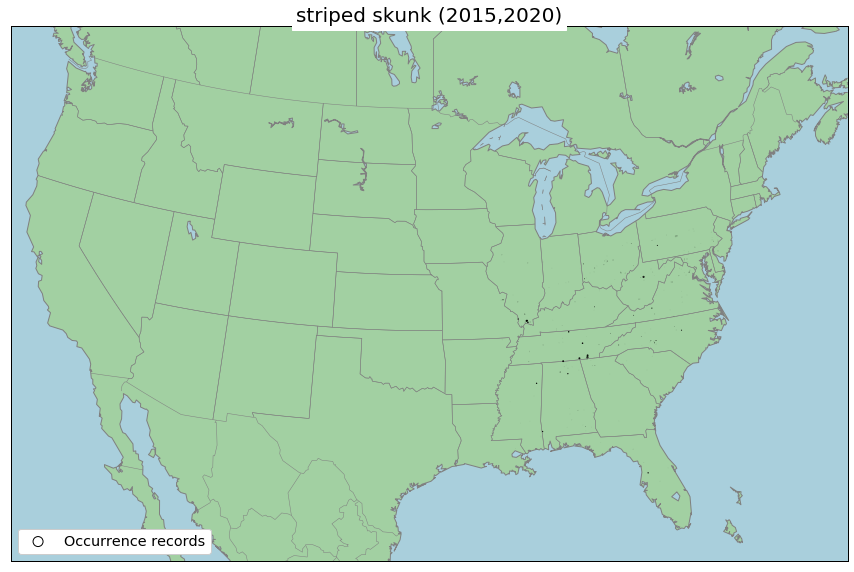

In [19]:
shp1 = {'file': '{0}{1}_polygons'.format(outDir, summary_name), 'column': None,
        'alias': 'Occurrence records', 'drawbounds': True, 'linewidth': .75, 'linecolor': 'k',
        'fillcolor': None, 'marker':'o'}

# Display occurrence polygons
map_these=[shp1]
    
title="{1} ({0})".format(years, common_name)
functions.MapShapefilePolygons(map_these=map_these, title=title)

### Years represented

Text(0.5, 1.0, 'Occurrences per Year')

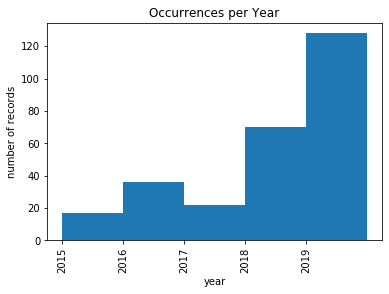

In [20]:
occ_years = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%Y', occurrenceDate) FROM occurrences").fetchall()]
years = connjup.execute("SELECT years_range FROM gbif_requests WHERE request_id = '{0}'".format(gbif_req_id)).fetchone()[0]
years = years.split(',')
yearsrng = list(range(int(years[0]), int(years[1]), 1))
binsnum = int(years[1]) - int(years[0])
plt.hist(occ_years, bins=binsnum)
plt.ylabel("number of records")
plt.xlabel("year")
plt.xticks(yearsrng, rotation=90)
plt.title("Occurrences per Year")

### Months represented

Text(0.5, 1.0, 'Occurrences per Month')

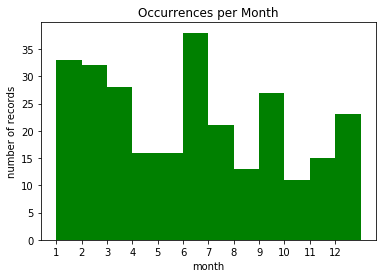

In [21]:
occ_months = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%m', occurrenceDate) FROM occurrences").fetchall()]
plt.hist(occ_months, bins=range(1, 14), color="g")
plt.ylabel("number of records")
plt.xlabel("month")
plt.xticks(range(1, 13))
plt.title("Occurrences per Month")

### Distribution of coordinate uncertainty values

Text(0.5, 1.0, 'Coordinate Uncertainty')

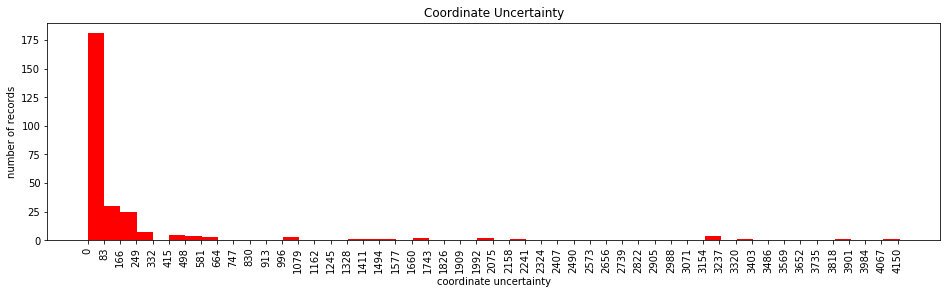

In [22]:
occ_cert = [int(x[0]) for x in curs_occ.execute("SELECT coordinateUncertaintyInMeters FROM occurrences").fetchall()]
maxi = np.max(occ_cert)
plt.figure(figsize=(16,4))
plt.hist(occ_cert, bins=50, color="r")
plt.xticks(range(0, maxi, int(maxi/50)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

Text(0.5, 1.0, 'Coordinate Uncertainty - Zoomed In')

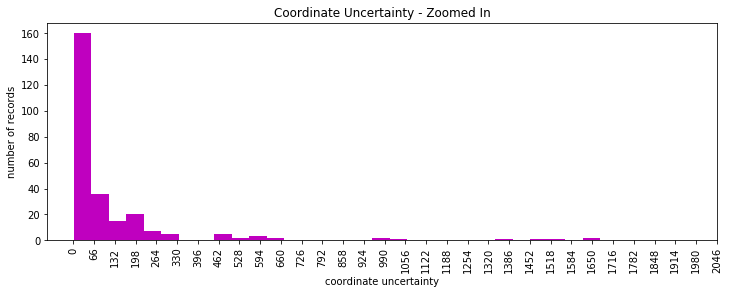

In [23]:
rng_max = 2000
occ_cert2 = [x for x in occ_cert if x <= rng_max]
plt.figure(figsize=(12,4))
plt.hist(occ_cert2, bins=30, color="m", align='mid')
plt.xticks(range(0, rng_max + 100, int(rng_max/30.)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty - Zoomed In")

### Establishment means reported

In [24]:
establishment = curs_occ.execute("SELECT vals FROM unique_values WHERE field = 'establishment' AND step = 'filter';").fetchall()[0]
for est in establishment:
    est = est.replace('[', '').strip().replace(']', '').replace("'", "")
    print(est)

UNKNOWN


### Identification qualifiers included

In [25]:
quali = curs_occ.execute("SELECT DISTINCT vals FROM unique_values WHERE field = 'IDqualifier' AND step = 'filter';").fetchall()[0]
for q in quali:
    q = q.replace('[', '').strip().replace(']', '').replace("'", "")
    print(q)

UNKNOWN


### Remarks included

In [26]:
remarks = curs_occ.execute("SELECT DISTINCT remarks FROM occurrences;").fetchall()
if len(remarks) <= 20:
    try:
        for rem in remarks:
            if rem[0][0:1] == ';':
                print(rem[0][2:])
            else:
                print(rem[0])
    except:
        pass
else:
    print("More than 20 remarks, consult the occurrence database.")

More than 20 remarks, consult the occurrence database.


### Attributes returned for the records in the request (pre-filters)

In [27]:
fields_summary = pd.read_sql("SELECT * FROM gbif_fields_returned", conn_occ)#, index_col='index')
fields_summary.index.name = 'Field'
pd.set_option('display.max_rows', 250)
print(fields_summary)

                                  attribute  included(n)  populated(n)
Field                                                                 
0                    acceptedScientificName          311           311
1                          acceptedTaxonKey          311           311
2                             basisOfRecord          311           311
3                             catalogNumber          311           311
4                                     class          311           311
5                                  classKey          311           311
6                            collectionCode          311           311
7             coordinateUncertaintyInMeters          249           249
8                                   country          311           311
9                               countryCode          311           311
10                                  crawlId          311           311
11                               datasetKey          311           311
12    

### Runtime

In [28]:
t2 = datetime.now()
print(t2 - t1)

0:00:21.942274
